In [1]:
import mne
import sys
import numpy as np
import pandas as pd
from mne_bids import BIDSPath, read_raw_bids
from bids import BIDSLayout
from util.io.iter_BIDSPaths import *

### Averaging in the time domain

In [2]:
# Set params
SUB = '4'
TASK = 'dichotic'
RUN = '1'
FPATH = f'/project2/hcn1/dichotic_pitch_tracking/data/bids/derivatives/preprocessing/sub-{SUB}/sub-{SUB}_task-{TASK}_run-{RUN}_desc-clean_epo.fif.gz'

In [11]:
# Load data
epochs = mne.read_epochs(FPATH, preload = True)

Reading /project2/hcn1/dichotic_pitch_tracking/data/bids/derivatives/preprocessing/sub-4/sub-4_task-dichotic_run-1_desc-clean_epo.fif.gz ...
    Found the data of interest:
        t =    -400.00 ...     450.00 ms
        0 CTF compensation matrices available
Not setting metadata
1465 matching events found
No baseline correction applied
0 projection items activated


In [4]:
# Change to (tone number 1/2/3, left/right l/r, attended/unattended True/False)
# tone 1, left, attended: 21*
# tone 2, left, attended: 22*
# tone 3, left, attended: 23*
# tone 1, right, attended: 1*1
# tone 2, right, attended: 1*2
# tone 3, right, attended: 1*3
# tone 1, left, unattended: 11*
# tone 2, left, unattended: 12*
# tone 3, left, unattended: 13*
# tone 1, right, unattended: 2*1
# tone 2, right, unattended: 2*2
# tone 3, right, unattended: 2*3

cond_dict = {
    (1, 'l', True): ['211', '212', '213'],
    (2, 'l', True): ['221', '222', '223'],
    (3, 'l', True): ['231', '232', '233'],
    (1, 'r', True): ['111', '121', '131'],
    (2, 'r', True): ['112', '122', '132'],
    (3, 'r', True): ['113', '123', '133'],
    (1, 'l', False): ['111', '112', '113'],
    (2, 'l', False): ['121', '122', '123'],
    (3, 'l', False): ['131', '132', '133'],
    (1, 'r', False): ['211', '221', '231'],
    (2, 'r', False): ['212', '222', '232'],
    (3, 'r', False): ['213', '223', '233']
}

In [14]:
# Separate channels by hemisphere
all_channels = epochs.ch_names
midline_channels = ['AFz', 'Fz', 'FCz', 'Cz', 'CPz', 'Pz', 'POz', 'Oz']
left_channels = ['AF3', 'C1','C3','C5','T7','CP1','CP3','CP5','F1','F3','F5','F7','FC1','FC3','FC5','FT7','FT9','Fp1','O1','P1','P3','P5','P7','PO3','PO7','TP7','TP9']
right_channels = ['AF4','C2','C4','C6','T8','CP2','CP4','CP6','F2','F4','F6','F8','FC2','FC4','FC6','FT10','FT8','Fp2','O2','P2','P4','P6','P8','PO4','PO8','TP10','TP8']

# Checks
print('Checks:')
all_channels_set = set(epochs.ch_names)
midline_channels_set = set(midline_channels)
left_channels_set = set(left_channels)
right_channels_set = set(right_channels)
print(all_channels_set - midline_channels_set - left_channels_set - right_channels_set)

intersection = all_channels_set & right_channels_set # channels that are in both sets
right_missing = list(right_channels_set - intersection)
print(f'Channels missing from right hemisphere: {right_missing}')
for missing_item in right_missing:
    print(f'Removing {missing_item} from both hemispheres')
    index = right_channels.index(missing_item)
    right_channels.pop(index)
    left_channels.pop(index)

intersection = all_channels_set & left_channels_set # channels that are in both sets
left_missing = list(left_channels_set - intersection)
print(f'Channels missing from left hemisphere: {left_missing}')
for missing_item in left_missing:
    print(f'Removing {missing_item} from both hemispheres')
    index = left_channels.index(missing_item)
    right_channels.pop(index)
    left_chanenls.pop(index)

print(f'Number of channels in manually created lists: {len(midline_channels) + len(left_channels) + len(right_channels)}')
print(f'Number of channels in epochs object: {len(all_channels)}')

Checks:
set()
Channels missing from right hemisphere: ['T8']
Removing T8 from both hemispheres
Channels missing from left hemisphere: []
Number of channels in manually created lists: 60
Number of channels in epochs object: 61


In [23]:
right_channels = ['AF4','C2','C4','C6','CP2','CP4','CP6','F2','F4','F6','F8','FC2','FC4','FC6','FT10','FT8','Fp2','O2','P2','P4','P6','P8','PO4','PO8','T8','TP10','TP8']
for missing_item in right_missing:
    right_channels.remove(missing_item)
# right_channels.remove('T8')
print(right_channels)

['AF4', 'C2', 'C4', 'C6', 'CP2', 'CP4', 'CP6', 'F2', 'F4', 'F6', 'F8', 'FC2', 'FC4', 'FC6', 'FT10', 'FT8', 'Fp2', 'O2', 'P2', 'P4', 'P6', 'P8', 'PO4', 'PO8', 'TP10', 'TP8']


In [116]:
# Average across each condition
#     Event tags have 3 numbers (stream, tone in left ear, tone in right ear)
#         stream {1: right, 2: left}
#         tone in left ear {1: 130, 2: 200, 3: 280}
#         tone in right ear {1: 130, 2: 200, 3: 280}
#
#     Average across each tone in the time domain
#         tone duration: 400 msec
#         baseline: 400 msec
#         buffer: 50 msec

evokeds = pd.DataFrame()

# For each condition
for key in cond_dict.keys():

    # Get the correct epochs
    cond_epochs = epochs[cond_dict[key]]
    
    # Average across the time domain
    cond_evoked = cond_epochs.average()
    
    # Compute psd for epoch and baseline TAKE BY HEMISPHERE
    P_left = cond_evoked.compute_psd(tmin = 0, tmax = 0.4, fmin = 100, fmax = 300, picks = left_channels)
    P0_left = cond_evoked.compute_psd(tmin = -0.4, tmax = 0, fmin = 100, fmax = 300, picks = left_channels)
    P_right = cond_evoked.compute_psd(tmin = 0, tmax = 0.4, fmin = 100, fmax = 300, picks = right_channels)
    P0_right = cond_evoked.compute_psd(tmin = -0.4, tmax = 0, fmin = 100, fmax = 300, picks = right_channels)
    
    # Extract the data only
    P_left = P_left.get_data()
    P0_left = P0_left.get_data()
    P_right = P_right.get_data()
    P0_right = P0_right.get_data()
    
    # Take log
    dB_left = 10*np.log10(P_left/P0_left)
    dB_right = 10*np.log10(P_right/P0_right)
    
    # Take difference between hemispheres
    dB_diff = dB_right - dB_left
    
    # Create row for data frame
    row = {
        'sub': SUB,
        'task': TASK,
        'run': RUN,
        'tone_num': key[0],
        'stream': key[1],
        'attended': key[2],
        'dB_diff': dB_diff}
    
    # Add to dataframe
    evokeds = evokeds.append(row, ignore_index = True)

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows


/tmp/ipykernel_34477/2475469666.py:50: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  evokeds = evokeds.append(row, ignore_index = True)


In [114]:
np.shape(P_left.get_data())

(27, 80)

In [ ]:
def get_psd(tmin, tmax, ch_names):
    

In [69]:
psd

Data type,Power Spectrum
Units,eeg: V²/Hz
Data source,Evoked
Dims,"channel, freq"
Estimation method,multitaper
Number of channels,62
Number of frequency bins,1026
Frequency range,0.00 – 2498.78 Hz


In [62]:
np.shape(psd.get_data())

(62, 1151)

In [60]:
int(1151/2)

575

In [57]:
11/2

5.5

In [59]:
l = ['a', 'b', 'c', 'd']
l[0:2]

['a', 'b']

In [10]:
np.shape(cond_evoked.get_data())

(62, 4251)

In [13]:
conditions = cond_dict[key]
evokeds = {c:epochs[c].average() for c in conditions}

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


In [14]:
for c in evokeds.keys():
    evokeds[c].plot_joint(title=c);

AttributeError: module 'matplotlib' has no attribute 'get_data_path'

### Averaging in the spectral domain

No projector specified for this dataset. Please consider the method self.add_proj.
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


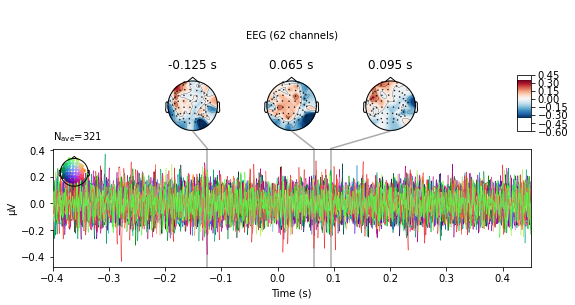

In [18]:
# times = 
# for c in evokeds.keys():
evokeds.plot_joint();

In [23]:
cond_evoked

<Evoked | '0.30 × 211 + 0.39 × 212 + 0.31 × 213' (average, N=321), -0.4 – 0.45 s, baseline -0.4 – 0 s, 62 ch, ~2.1 MB>